Core Libraries:

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    BatchNormalization, Conv2D, AveragePooling2D, MaxPooling2D,
    ZeroPadding2D, Activation, Dense, Flatten, Input, Add, ReLU,
    MaxPool2D,Dropout,GlobalAveragePooling2D
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
from scipy.ndimage import rotate
%matplotlib inline
from tensorflow.keras.applications import Xception
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
sns.set(style='white', context='notebook', palette='deep')

WikiArt Dataset:

In [2]:
datapath = '/kaggle/input/wikiart'
genres_datapath = '/kaggle/input/genres-ds'
# Load and process genre_class.txt
data_classes = pd.read_csv(genres_datapath+'/genre_class.txt')
data_classes = {}
with open(genres_datapath + '/genre_class.txt', 'r') as f:
    for line in f:
        index, label = line.strip().split(' ', 1)
        data_classes[int(index)] = label
print(data_classes)

{0: 'abstract_painting', 1: 'cityscape', 2: 'genre_painting', 3: 'illustration', 4: 'landscape', 5: 'nude_painting', 6: 'portrait', 7: 'religious_painting', 8: 'sketch_and_study', 9: 'still_life'}


In [3]:
# Load train and validation data
data_valid = pd.read_csv(genres_datapath+'/genre_val.csv')
data_train = pd.read_csv(genres_datapath+'/genre_train.csv')
data_train.head()

,filename,genre
0,Post_Impressionism/vincent-van-gogh_ears-of-wh...,4
1,Symbolism/theodor-severin-kittelsen_kvitebj-rn...,3
2,Expressionism/martiros-saryan_mother-of-the-ar...,6
3,Early_Renaissance/leonardo-da-vinci_study-for-...,8
4,Expressionism/jose-gutierrez-solana_old-mounta...,6


In [4]:
# Map labels to class names in train data
data_train['class_name'] = data_train['genre'].map(data_classes)
data_valid['class_name'] = data_valid['genre'].map(data_classes)
data_train.head()

,filename,genre,class_name
0,Post_Impressionism/vincent-van-gogh_ears-of-wh...,4,landscape
1,Symbolism/theodor-severin-kittelsen_kvitebj-rn...,3,illustration
2,Expressionism/martiros-saryan_mother-of-the-ar...,6,portrait
3,Early_Renaissance/leonardo-da-vinci_study-for-...,8,sketch_and_study
4,Expressionism/jose-gutierrez-solana_old-mounta...,6,portrait


In [5]:
# Check for missing values
print(f"train:\n{data_train.isnull().sum()}\n")
print(f"validation:\n{data_valid.isnull().sum()}")

train:
filename      0
genre         0
class_name    0
dtype: int64

validation:
filename      0
genre         0
class_name    0
dtype: int64


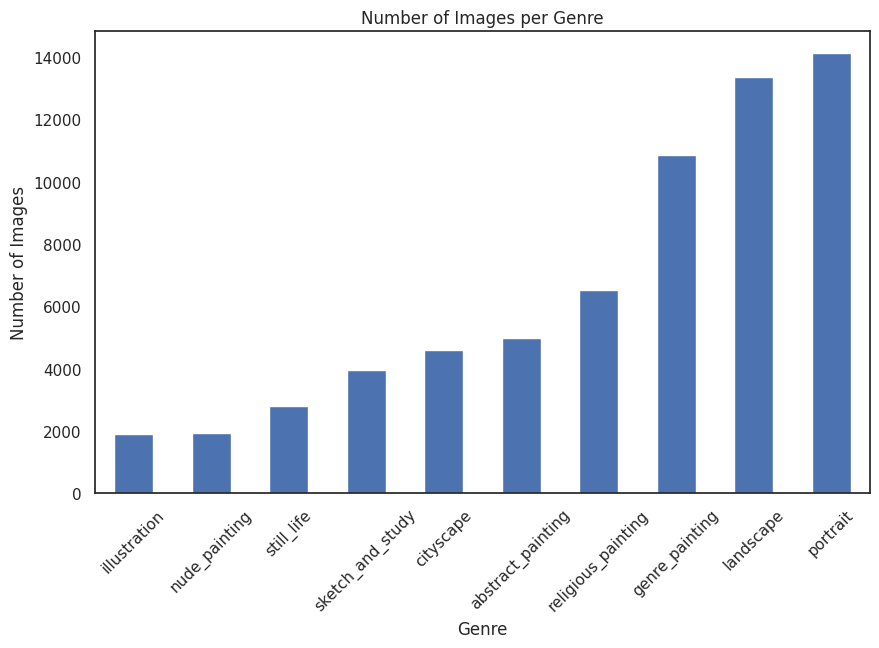

In [6]:
# Visualize the genres distribution
combined_data = (data_train['class_name'].value_counts() + data_valid['class_name'].value_counts())
combined_data.sort_values().plot(kind='bar', figsize=(10, 6), legend=False)
plt.title("Number of Images per Genre")
plt.ylabel("Number of Images")
plt.xlabel("Genre")
plt.xticks(rotation=45)
plt.show()

In [7]:
# Function to identify invalid filenames
def find_invalid_filenames(dataframe, base_dir):
    invalid_files = []
    for filename in dataframe['filename']:
        file_path = os.path.join(base_dir, filename)
        if not os.path.isfile(file_path):
            invalid_files.append(filename)
    return invalid_files

invalid_filenames_train = find_invalid_filenames(data_train, datapath)
invalid_filenames_valid = find_invalid_filenames(data_valid, datapath)

print(f"Number of invalid files in train data: {len(invalid_filenames_train)}")
print(f"Number of invalid files in valid data: {len(invalid_filenames_valid)}")

Number of invalid files in train data: 423
Number of invalid files in valid data: 193


In [8]:
# Remove invalid filenames from both train and validation datasets
data_train = data_train[~data_train['filename'].isin(invalid_filenames_train)]
print(f"Number of valid rows in train after cleaning: {len(data_train)}")

data_valid = data_valid[~data_valid['filename'].isin(invalid_filenames_valid)]
print(f"Number of valid rows in valid after cleaning: {len(data_valid)}")


Number of valid rows in train after cleaning: 45079
Number of valid rows in valid after cleaning: 19298


In [9]:
# Split the training data into training and testing sets (80% train, 20% test)
data_train, data_test = train_test_split(data_train, test_size=0.2, random_state=42, stratify=data_train['genre'])
print(data_train.shape)
print(data_valid.shape)
print(data_test.shape)

(36063, 3)
(19298, 3)
(9016, 3)


In [10]:
# Balance classes for training
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(data_train['class_name']),
    y=data_train['class_name']
)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(class_weights_dict)

{0: 1.2962976276060387, 1: 1.4120203602192638, 2: 0.6066105971404542, 3: 3.415056818181818, 4: 0.48746958637469584, 5: 3.3672268907563025, 6: 0.45928425878757007, 7: 0.9888401425829448, 8: 1.6399727148703955, 9: 2.3132135984605515}


In [11]:
# Apply augmentation on training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=data_train,
    directory=datapath,
    x_col='filename',
    y_col='class_name',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
)

# Validation generator
valid_datagen = ImageDataGenerator(
    rescale=1./255
)
valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=data_valid,
    directory=datapath,
    x_col='filename',
    y_col='class_name',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
)

# Testing generator
test_datagen = ImageDataGenerator(
    rescale=1./255
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=data_test,
    directory=datapath,
    x_col='filename',
    y_col='class_name',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
)

Found 36063 validated image filenames belonging to 10 classes.
Found 19298 validated image filenames belonging to 10 classes.
Found 9016 validated image filenames belonging to 10 classes.


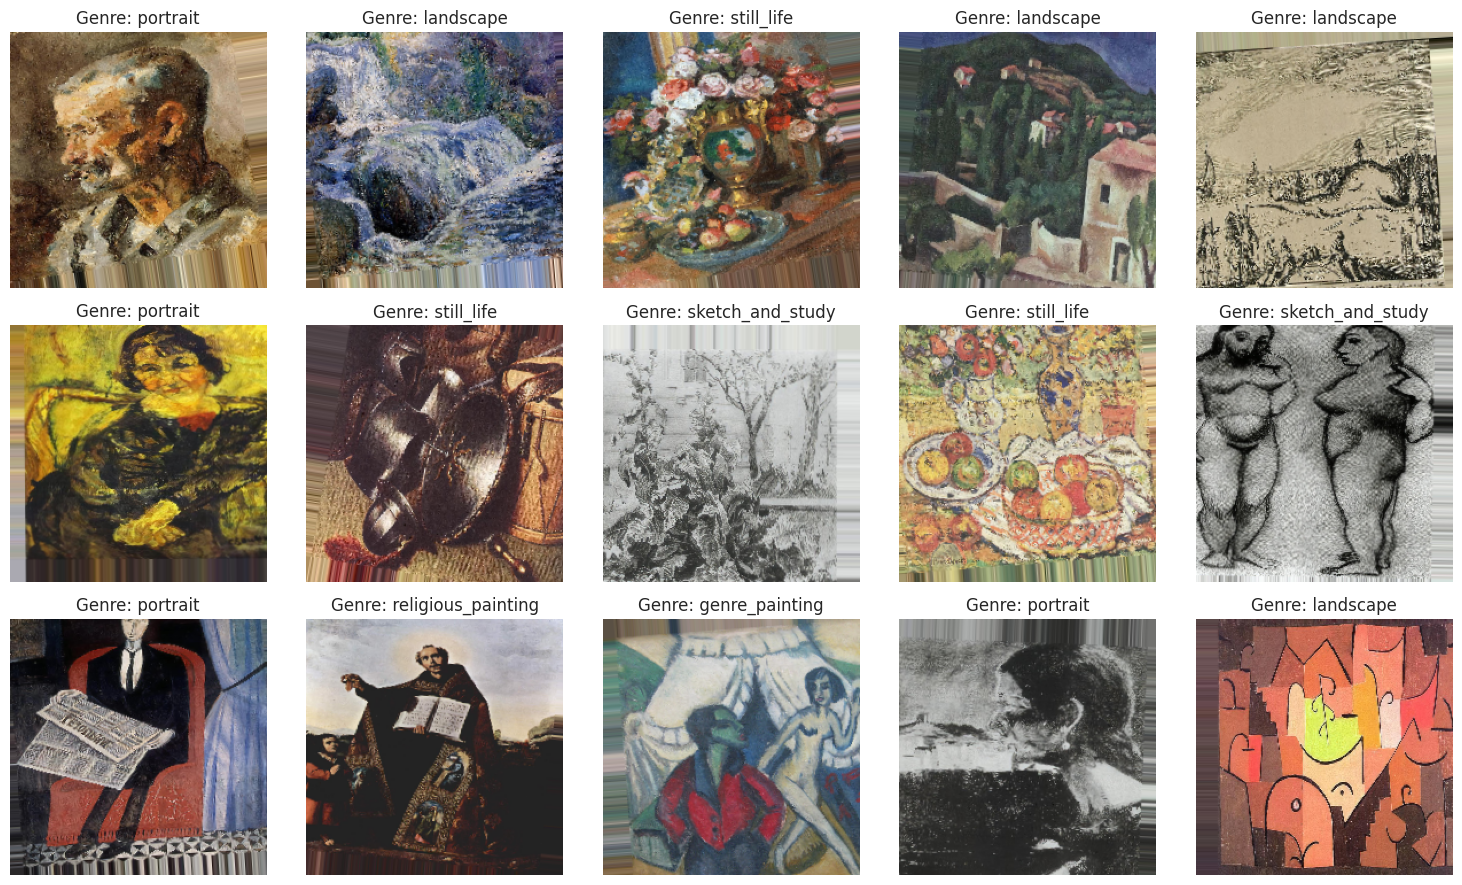

In [12]:
# Visualize images and labels from a batch of the train generator
image_batch, label_batch = next(train_generator)
plt.figure(figsize=(15, 9))
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(image_batch[i])
    plt.title(f"Genre: {data_classes[np.argmax(label_batch[i])]}", fontsize=12)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [13]:
print(len(train_generator))

1127


Xception Pre-trained Model:

In [14]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

inputs = Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)

x = GlobalAveragePooling2D()(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)


outputs = Dense(10, activation='softmax')(x)

modelFunXception = Model(inputs, outputs)

modelFunXception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
modelFunXception.summary()

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

historyFunXception = modelFunXception.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=15,
    callbacks=[reduce_lr, early_stop],
    verbose=1,
    class_weight = class_weights_dict
)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,125,554 (80.59 MB)

 Trainable params: 263,818 (1.01 MB)

 Non-trainable params: 20,861,736 (79.58 MB)

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734441597.661923      93 service.cc:145] XLA service 0x7deafc03ac90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734441597.661982      93 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734441597.661986      93 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


   1/1127 ━━━━━━━━━━━━━━━━━━━━ 7:12:38 23s/step - accuracy: 0.1250 - loss: 2.5932

I0000 00:00:1734441607.968495      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1127/1127 ━━━━━━━━━━━━━━━━━━━━ 1742s 2s/step - accuracy: 0.5515 - loss: 1.3632 - val_accuracy: 0.6329 - val_loss: 1.1029 - learning_rate: 0.0010
Epoch 2/15
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 1274s 1s/step - accuracy: 0.6322 - loss: 1.0440 - val_accuracy: 0.6163 - val_loss: 1.1379 - learning_rate: 0.0010
Epoch 3/15
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 1163s 1s/step - accuracy: 0.6373 - loss: 1.0153 - val_accuracy: 0.6395 - val_loss: 1.0712 - learning_rate: 0.0010
Epoch 4/15
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 1162s 1s/step - accuracy: 0.6533 - loss: 0.9754 - val_accuracy: 0.6429 - val_loss: 1.0406 - learning_rate: 0.0010
Epoch 5/15
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 1162s 1s/step - accuracy: 0.6542 - loss: 0.9594 - val_accuracy: 0.6419 - val_loss: 1.0532 - learning_rate: 0.0010
Epoch 6/15
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 1179s 1s/step - accuracy: 0.6563 - loss: 0.9333 - val_accuracy: 0.6349 - val_loss: 1.0861 - learning_rate: 0.0010
Epoch 7/15
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 1182s 1s/step - accuracy: 0.6627 

In [21]:
print("Base Model layers: ",len(base_model.layers))
print("My Model layers: ",len(modelFunXception.layers))

Base Model layers:  132
My Model layers:  6


In [26]:
from tensorflow.keras.optimizers import Adam
# Step 6: Unfreeze Some Layers of the Base Model for Fine-Tuning
base_model.trainable = True  # Unfreeze all layers

# Freeze the first 100 layers (adjust as needed)
for layer in base_model.layers[:100]:
    layer.trainable = False

# Recompile with a Lower Learning Rate for Fine-Tuning
optimizer_fine = Adam(learning_rate=1e-5)  # Smaller learning rate for fine-tuning
modelFunXception.compile(optimizer=optimizer_fine, loss='categorical_crossentropy', metrics=['accuracy'])

# Step 7: Fine-Tune the Model
fine_tune_epochs = 10
total_epochs = len(historyFunXception.epoch) + fine_tune_epochs

history_fine = modelFunXception.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=total_epochs,
    initial_epoch=historyFunXception.epoch[-1],
    callbacks=[early_stop, reduce_lr],
    verbose=1
)
print("My Model layers after fine tuning: ",len(modelFunXception.layers))

Epoch 15/25
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 1510s 1s/step - accuracy: 0.6444 - loss: 1.0586 - val_accuracy: 0.6761 - val_loss: 0.9700 - learning_rate: 1.0000e-05
Epoch 16/25
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 1279s 1s/step - accuracy: 0.7110 - loss: 0.8433 - val_accuracy: 0.6964 - val_loss: 0.9096 - learning_rate: 1.0000e-05
Epoch 17/25
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 1183s 1s/step - accuracy: 0.7291 - loss: 0.7744 - val_accuracy: 0.7030 - val_loss: 0.8821 - learning_rate: 1.0000e-05
Epoch 18/25
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 1141s 1s/step - accuracy: 0.7507 - loss: 0.7110 - val_accuracy: 0.7113 - val_loss: 0.8605 - learning_rate: 1.0000e-05
Epoch 19/25
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 1153s 1s/step - accuracy: 0.7535 - loss: 0.6936 - val_accuracy: 0.7134 - val_loss: 0.8539 - learning_rate: 1.0000e-05
Epoch 20/25
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 1166s 1s/step - accuracy: 0.7648 - loss: 0.6680 - val_accuracy: 0.7201 - val_loss: 0.8429 - learning_rate: 1.0000e-05
Epoch 21/25
1127/1127 ━━━━━━━━━━━━

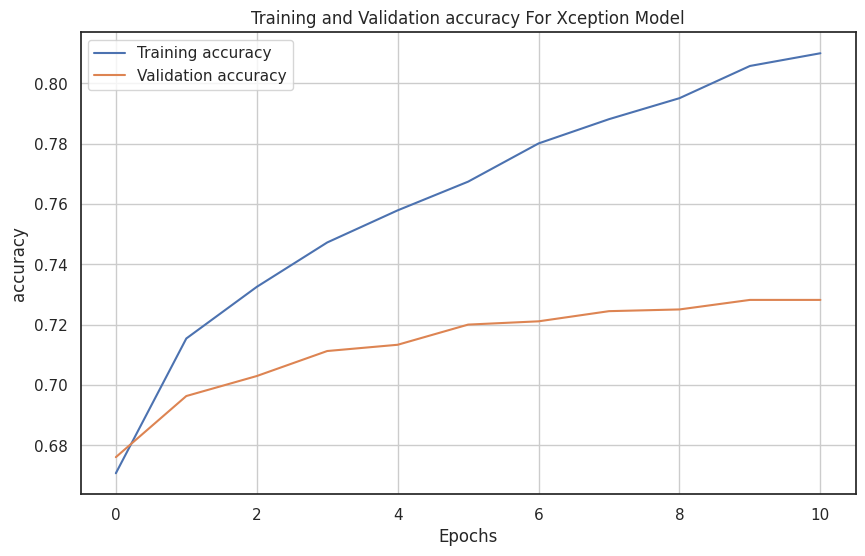

In [27]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))

# Plot Loss
plt.plot(history_fine.history['accuracy'], label='Training accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation accuracy For Xception Model')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.grid()
plt.show()

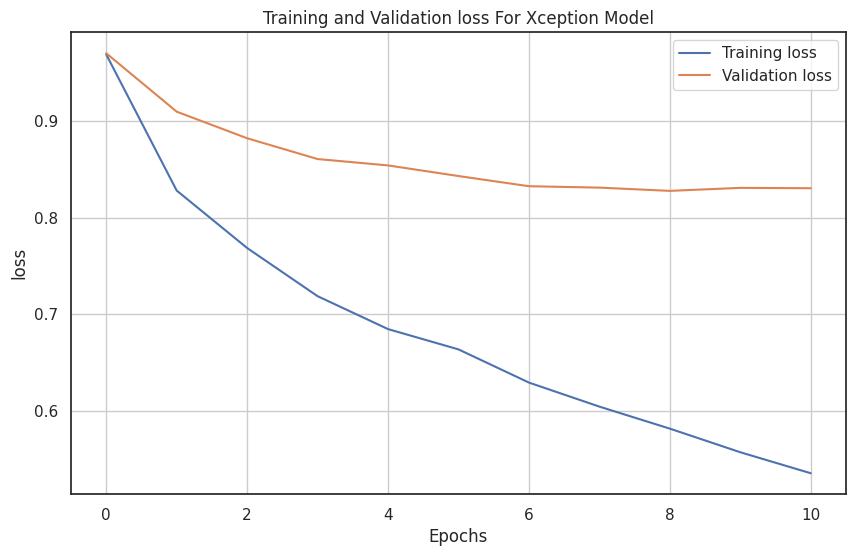

In [28]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))

# Plot Loss
plt.plot(history_fine.history['loss'], label='Training loss')
plt.plot(history_fine.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss For Xception Model')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

In [29]:
# Evaluate the model on the test dataset
loss, accuracy = modelFunXception.evaluate(test_generator, batch_size=32, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy*100:.2f}%")
#modelFunXception.save("modelFunXception.keras")

282/282 ━━━━━━━━━━━━━━━━━━━━ 199s 706ms/step - accuracy: 0.7260 - loss: 0.8420
Test Loss: 0.8243646025657654
Test Accuracy: 72.91%


In [30]:
# Predict labels
y_pred_xception = np.argmax(modelFunXception.predict(test_generator), axis=1)
y_true = test_generator.classes

282/282 ━━━━━━━━━━━━━━━━━━━━ 128s 446ms/step


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'abstract_painting'),
  Text(1, 0, 'cityscape'),
  Text(2, 0, 'genre_painting'),
  Text(3, 0, 'illustration'),
  Text(4, 0, 'landscape'),
  Text(5, 0, 'nude_painting'),
  Text(6, 0, 'portrait'),
  Text(7, 0, 'religious_painting'),
  Text(8, 0, 'sketch_and_study'),
  Text(9, 0, 'still_life')])

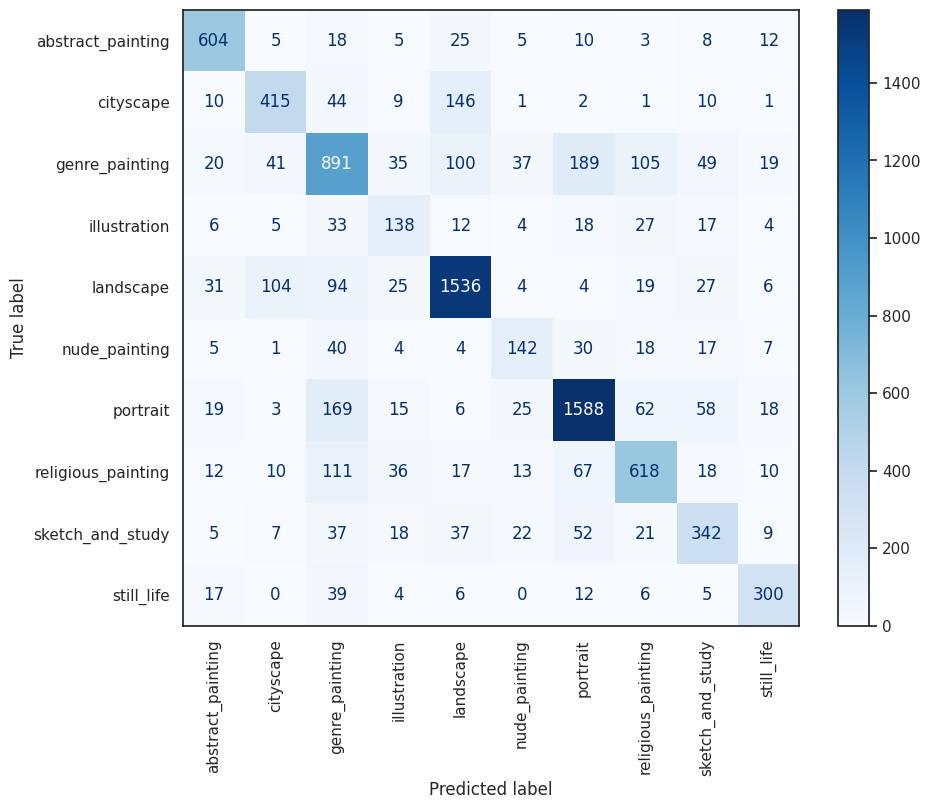

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_xception)

# Plot confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
fig, ax = plt.subplots(figsize=(10,8))
disp.plot(ax=ax,cmap='Blues')
plt.xticks(rotation=90)

In [32]:
report = classification_report(y_true, y_pred_xception, target_names=test_generator.class_indices.keys())
print(report)

                    precision    recall  f1-score   support

 abstract_painting       0.83      0.87      0.85       695
         cityscape       0.70      0.65      0.67       639
    genre_painting       0.60      0.60      0.60      1486
      illustration       0.48      0.52      0.50       264
         landscape       0.81      0.83      0.82      1850
     nude_painting       0.56      0.53      0.55       268
          portrait       0.81      0.81      0.81      1963
religious_painting       0.70      0.68      0.69       912
  sketch_and_study       0.62      0.62      0.62       550
        still_life       0.78      0.77      0.77       389

          accuracy                           0.73      9016
         macro avg       0.69      0.69      0.69      9016
      weighted avg       0.73      0.73      0.73      9016



282/282 ━━━━━━━━━━━━━━━━━━━━ 125s 442ms/step


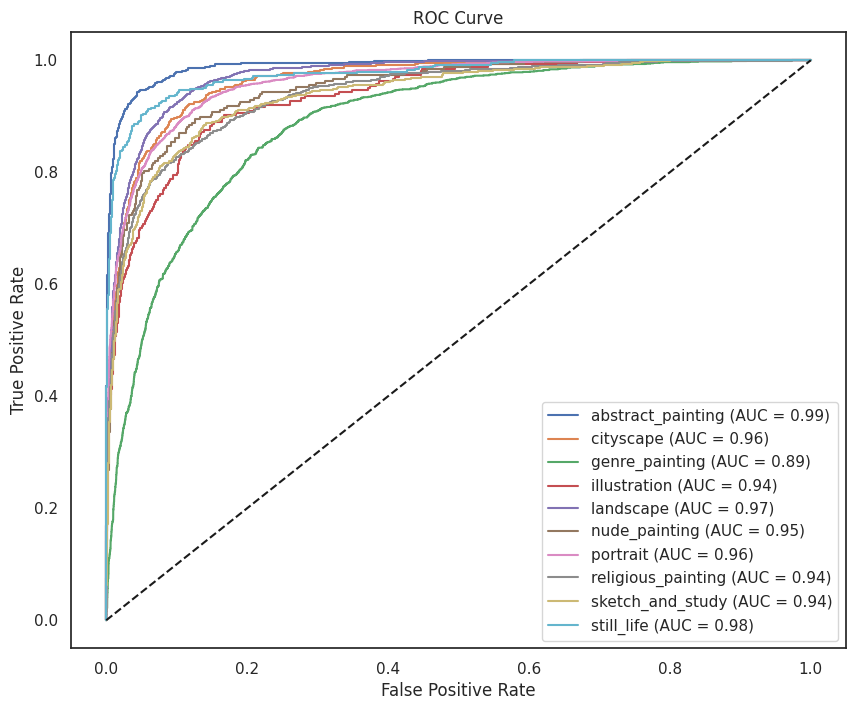

In [33]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
# Binarize the true labels
y_true_binarized = label_binarize(y_true, classes=np.arange(len(test_generator.class_indices)))

# Predict probabilities
y_pred_prob = modelFunXception.predict(test_generator)

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(test_generator.class_indices.keys()):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()